# Insitu Validation

Select a group of stations from Fluxnet and or ISMN, retrieve their time series, longitude and latitude coordinates.   

Load the whole windsat dataset and select for the lat-lon of the station/s

Load a pre-trained model and predict surface temperature

Produce some statistics + plots, comparing ERA5 Surtep, Insitu Surtep and Predicted Surtep

In [74]:
# 
from ismn.interface import ISMN_Interface
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))


from src.processing import windsat_datacube, model_preprocess
from src.model import transform_batch, plot_history

models_folder = "../../models/"
windsat_folder = "../../data/raw/Daily_Windsat/"
ISMN_path =  "../../data/raw/Data_separate_files_header_20170101_20171231_10665_0t0D_20240415.zip"
fluxnet_folder = "../../data/raw/FLUXNET_CH4_has_2017_data/"



In [75]:
#Print available models:
print("Filenames in YYYYmmddTHHMMSS format: ")
for filename in os.listdir(models_folder):
    if filename.endswith(".keras"):
        print(filename)

Filenames in YYYYmmddTHHMMSS format: 
2024_05_28T103102.keras
2024_05_28T112040.keras
2024_05_28T112132.keras
2024_05_28T114946.keras
2024_05_28T140627.keras
2024_05_28T140851.keras
2024_05_28T150756.keras
2024_05_29T105032.keras
2024_05_29T111241.keras
2024_05_29T114725.keras
2024_06_03T083543.keras
2024_06_03T083839.keras
2024_06_03T092350.keras
checkpoint.keras


In [76]:
# Load model
model_datestring = "2024_06_03T092350"
model_path = os.path.join(models_folder, model_datestring) + ".keras"
model = load_model(model_path)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 6)              │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 30)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,203 (12.52 KB)

 Trainable params: 1,063 (4.15 KB)

 Non-trainable params: 12 (48.00 B)

 Optimizer params: 2,128 (8.32 KB)

In [77]:
# Load the windsat dataset:
ds = windsat_datacube(windsat_folder)

# Process the dataset an select ascending passes
ascds = model_preprocess(ds)
ascds

<xarray.Dataset> Size: 784MB
Dimensions:         (day_number: 21, latitude_grid: 720, longitude_grid: 1440)
Coordinates:
  * day_number      (day_number) int32 84B 1 2 3 4 5 6 7 ... 16 17 18 19 20 21
  * latitude_grid   (latitude_grid) int32 3kB 0 1 2 3 4 ... 715 716 717 718 719
  * longitude_grid  (longitude_grid) int32 6kB 0 1 2 3 4 ... 1436 1437 1438 1439
Data variables:
    surtep_ERA5     (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
    tbtoa_18Ghz_V   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_18Ghz_H   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_V   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    tbtoa_37Ghz_H   (day_number, latitude_grid, longitude_grid) float32 87MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_18Ghz      (day_number, latitude_grid, longitude_grid) float64 174MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    time_37Ghz      (day_number, latitude_grid, longitude_grid) float64 174MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [78]:
# Load ISMN data
ismn_data = ISMN_Interface(ISMN_path, parallel=True)

Found existing ismn metadata in ..\..\data\raw\python_metadata\Data_separate_files_header_20170101_20171231_10665_0t0D_20240415.csv.


In [79]:
# Select the stations that have surface temperature
# Get the ids for the USCRN network and subset from the whole dataset.
ids = ismn_data.get_dataset_ids(
    variable=["surface_temperature"],
    filter_meta_dict={"network": "USCRN"},
)
uscrn_data = ismn_data.subset_from_ids(ids)
uscrn_data

Found existing ismn metadata in ..\..\data\raw\python_metadata\Data_separate_files_header_20170101_20171231_10665_0t0D_20240415.csv.


ismn.base.IsmnRoot Zip at ..\..\data\raw\Data_separate_files_header_20170101_20171231_10665_0t0D_20240415.zip
with Networks[Stations]:
------------------------
  USCRN: ['Aberdeen_35_WNW', 'Arco_17_SW', 'Asheville_13_S', 'Asheville_8_SSW', 'Austin_33_NW', 'Avondale_2_N', 'Baker_5_W', 'Batesville_8_WNW', 'Bedford_5_WNW', 'Blackville_3_W', 'Bodega_6_WSW', 'Boulder_14_W', 'Bowling_Green_21_NNE', 'Brigham_City_28_WNW', 'Bronte_11_NNE', 'Brunswick_23_S', 'Buffalo_13_ESE', 'Cape_Charles_5_ENE', 'Champaign_9_SW', 'Charlottesville_2_SSE', 'Chatham_1_SE', 'Chillicothe_22_ENE', 'Coos_Bay_8_SW', 'Cortez_8_SE', 'Corvallis_10_SSW', 'Crossville_7_NW', 'Darrington_21_NNE', 'Denio_52_WSW', 'Des_Moines_17_E', 'Dillon_18_WSW', 'Dinosaur_2_E', 'Durham_11_W', 'Durham_2_N', 'Durham_2_SSW', 'Edinburg_17_NNE', 'Elgin_5_S', 'Elkins_21_ENE', 'Everglades_City_5_NE', 'Fairhope_3_NE', 'Fallbrook_5_NE', 'Gadsden_19_N', 'Gaylord_9_SSW', 'Goodridge_12_NNW', 'Goodwell_2_E', 'Goodwell_2_SE', 'Harrison_20_SSE', 'Holly_

In [80]:
# Extract the longitude and latitude of the sensors in the uscrn network
valid_sensors = []
for network, station, sensor in uscrn_data.collection.iter_sensors(depth=[0, 0]):
    if (
        np.min(sensor.data["surface_temperature"]) > -100
    ):  # Some data will have badly recovered LST
        valid_sensors.append((network, station, sensor))

len(valid_sensors)

c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated an

113

In [81]:
# Retrieve the data into a dataframe

data_list = []
for network, station, sensor in valid_sensors[:] : 

    sensor_obj = uscrn_data[network.name][station.name][sensor.name]
    metadata = sensor_obj.metadata.to_pd()

    sensor_lat = metadata["latitude"]["val"]
    sensor_lon = metadata["longitude"]["val"]

    data_list.append(
        (
            sensor_obj.data,
            (sensor_lon,sensor_lat)
        )
    )

data_list[0]

c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  readf = lambda f: pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\Lib\site-packages\ismn\filehandlers.py:618: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated an

(                     surface_temperature surface_temperature_flag  \
 date_time                                                           
 2017-01-01 00:00:00                 -6.8                        G   
 2017-01-01 01:00:00                 -8.5                        G   
 2017-01-01 02:00:00                 -8.9                        G   
 2017-01-01 03:00:00                 -8.7                        G   
 2017-01-01 04:00:00                 -8.9                        G   
 ...                                  ...                      ...   
 2017-12-30 20:00:00                -22.4                        G   
 2017-12-30 21:00:00                -21.7                        G   
 2017-12-30 22:00:00                -22.9                        G   
 2017-12-30 23:00:00                -23.7                        G   
 2017-12-31 00:00:00                -24.6                        G   
 
                      surface_temperature_orig_flag  
 date_time                        

In [82]:
# sensor_obj = uscrn_data[network.name][station.name][sensor.name]
# sensor_lat = sensor_obj.metadata.to_pd()["latitude"]["val"]
# sensor_lon = sensor_obj.metadata.to_pd()["longitude"]["val"]
# print(sensor_lat,sensor_lon)

In [146]:
# Testing with a single sensor
sensor_data, sensor_coords = data_list[-7]

# Convert the sensor data from ºC to K 
sensor_data["surface_temperature"] = sensor_data["surface_temperature"].apply(lambda x: x + 273.15)

sensor_data

,surface_temperature,surface_temperature_flag,surface_temperature_orig_flag
date_time,,,
2017-01-01 00:00:00,279.15,G,0
2017-01-01 01:00:00,278.95,G,0
2017-01-01 02:00:00,279.35,G,0
2017-01-01 10:00:00,279.95,G,0
2017-01-01 11:00:00,279.95,G,0
...,...,...,...
2017-12-30 20:00:00,288.35,G,0
2017-12-30 21:00:00,285.55,G,0
2017-12-30 22:00:00,281.95,G,0


In [175]:
print(sensor_data.reset_index()["date_time"][0].__class__)
print(sensor_data.reset_index()["date_time"][0].tzinfo) # No timezone info .. .

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
None


In [147]:
# Selec the closest gird point to the sensor

# Transform the lat -lon (-180,180) into the grid

# Linear interpolation, then roud then to the closest grid point:
def map_lat(x, in_min=-90, in_max=90, out_min=0, out_max=719):
    return round( out_min + ( (x - in_min) / (in_max - in_min) ) * (out_max - out_min))

def map_lon(x, in_min=-180, in_max=180, out_min=0, out_max=1439):
    return round(out_min + ( (x - in_min) / (in_max - in_min) ) * (out_max - out_min))

latg, long = map_lat(sensor_coords[1]), map_lon(sensor_coords[0])

latg, long

(494, 386)

In [148]:
# Selec the slice for the sensor in the dataset
sensor_ds = ascds.sel(latitude_grid = latg, longitude_grid = long)

# Transform it into a dataframe for prediction
sensor_df = sensor_ds.to_dataframe()
sensor_df.reset_index(inplace=True)
sensor_df.dropna(inplace=True)
sensor_df.drop(columns=["longitude_grid","latitude_grid"], inplace=True)
transfomed_df = transform_batch(sensor_df)

# # Drop the necessary variables, some models don´t use time of observation nor day_number:
transfomed_df = transfomed_df.drop(columns=["time_18Ghz","time_37Ghz","day_number"])


# Split the prediction and forward pass to get the model surtep, add the column to the untransformed data.

sensor_df["surtep_MODEL"] = model.predict(transfomed_df[[col for col in transfomed_df.columns if col != "surtep_ERA5"]])
sensor_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


,day_number,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz,surtep_MODEL
3,4,281.818085,33.625,276.625,269.470001,263.424988,270.790009,266.162476,5.368883e+08,5.368883e+08,284.787689
4,5,283.140839,33.625,276.625,270.257507,264.012512,271.595001,266.950012,5.369736e+08,5.369736e+08,285.550690
9,10,279.729431,33.625,276.625,271.592499,266.402496,272.274994,268.487488,5.374062e+08,5.374062e+08,285.262085
10,11,286.880737,33.625,276.625,275.542480,269.945007,276.597504,272.387512,5.374915e+08,5.374915e+08,290.730194
14,15,287.099182,33.625,276.625,276.517487,271.789978,277.062500,273.269989,5.378387e+08,5.378387e+08,290.976929
15,16,288.270355,33.625,276.625,276.919983,271.895020,277.695007,273.787506,5.379240e+08,5.379240e+08,291.745087
20,21,287.358795,33.625,276.625,275.017517,269.099976,276.372498,271.687500,5.383566e+08,5.383566e+08,291.269318


In [149]:
# Transform the time from senconds since 2000-01-01T00:00:00 into a datetime object.
from datetime import datetime, timedelta
def get_datetime_from_secods(seconds):
    reference_dt = datetime(2000,1,1,0,0,0)
    return reference_dt + timedelta(seconds=seconds)

sensor_df["time_18Ghz"] = sensor_df["time_18Ghz"].apply(lambda x : get_datetime_from_secods(x))
sensor_df["time_37Ghz"] = sensor_df["time_37Ghz"].apply(lambda x : get_datetime_from_secods(x))
sensor_df

,day_number,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,time_18Ghz,time_37Ghz,surtep_MODEL
3,4,281.818085,33.625,276.625,269.470001,263.424988,270.790009,266.162476,2017-01-04 23:38:24.658551,2017-01-04 23:38:36.258551,284.787689
4,5,283.140839,33.625,276.625,270.257507,264.012512,271.595001,266.950012,2017-01-05 23:19:56.696757,2017-01-05 23:20:06.746757,285.550690
9,10,279.729431,33.625,276.625,271.592499,266.402496,272.274994,268.487488,2017-01-10 23:29:23.011583,2017-01-10 23:29:33.461583,285.262085
10,11,286.880737,33.625,276.625,275.542480,269.945007,276.597504,272.387512,2017-01-11 23:11:10.357243,2017-01-11 23:11:20.657243,290.730194
14,15,287.099182,33.625,276.625,276.517487,271.789978,277.062500,273.269989,2017-01-15 23:38:57.839431,2017-01-15 23:39:09.539431,290.976929
15,16,288.270355,33.625,276.625,276.919983,271.895020,277.695007,273.787506,2017-01-16 23:20:28.788308,2017-01-16 23:20:38.788308,291.745087
20,21,287.358795,33.625,276.625,275.017517,269.099976,276.372498,271.687500,2017-01-21 23:29:54.887223,2017-01-21 23:30:05.437223,291.269318


C:\Users\andre\AppData\Local\Temp\ipykernel_20304\768648658.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


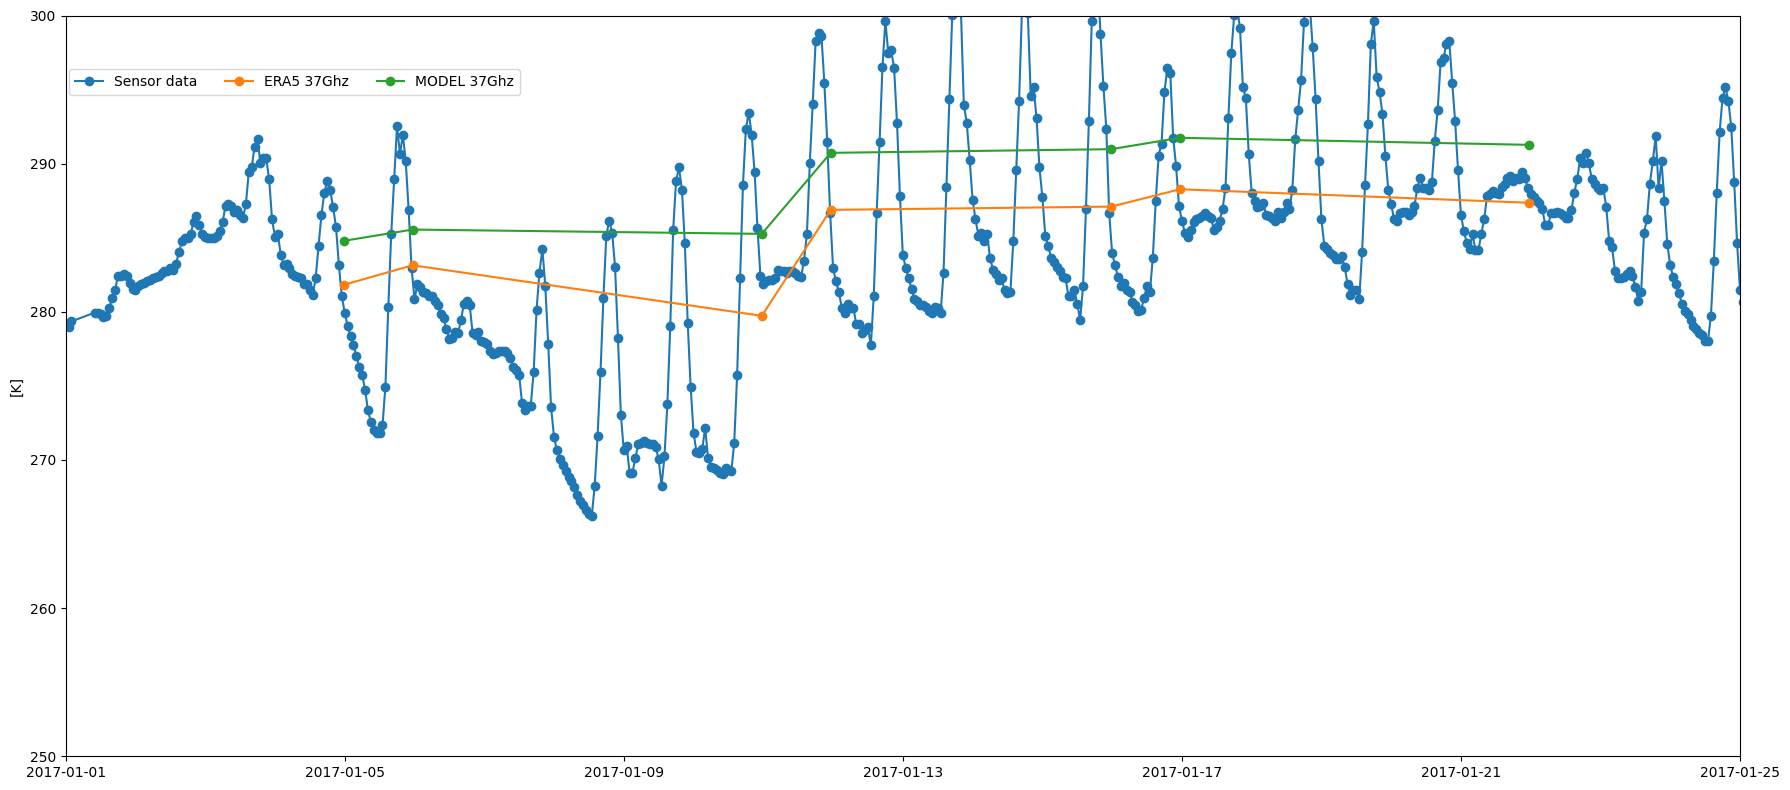

In [178]:
# Now we can plot both the sensor data and the predicted surtep, alongiside the ERA5 prediction:
fig, ax = plt.subplots(1,1,figsize =(18,8))

ax.plot(sensor_data["surface_temperature"], marker = "o", label = "Sensor data")

# Both times are basically the same, so we could remove one from training as well.
# ax.plot(sensor_df["time_18Ghz"], sensor_df["surtep_ERA5"], marker="*", label = "ERA5 18Ghz")
# ax.plot(sensor_df["time_18Ghz"], sensor_df["surtep_MODEL"], marker="*", label = "MODEL 18Ghz")

ax.plot(sensor_df["time_37Ghz"], sensor_df["surtep_ERA5"], marker="o", label = "ERA5 37Ghz")
ax.plot(sensor_df["time_37Ghz"], sensor_df["surtep_MODEL"], marker="o", label = "MODEL 37Ghz")



# Crop the image so it only shows the range where we have prdictions (localy from Jan1 to Jan 21)

ax.set_xlim(
    [datetime(2017,1,1),datetime(2017,1,25) ]
)
ax.set_ylim([
    250, 300
])

ax.set_ylabel("[K]")

fig.legend(loc = "upper left", ncol=3, borderaxespad=5)
fig.tight_layout()
fig.show()



# TODO:  
Aggregate all predictions for all the stations and create some histograms of the error values both from ERA5 and the MODEL

The metadata on the station's time of measurement is missing, googling th ismn then uscrn networks seems to suggest that the measured date is in local time for each sensor, which needs to be corrected if true.

Maybe do this in a Bokeh graph to switch between sensors easily ? 

In [151]:
# select the closest date_time for each prdiction and calculate the error:

""" 
USCRN has data measurements each hour, so we need to round to the nearest hour for the predictions as well (or some other method ? )
"""


' \nUSCRN has data measurements each hour, so we need to round to the nearest hour for the predictions as well (or some other method ? )\n'

In [163]:
station.lon, station.lat, sensor_coords

(-114.1884, 32.835, (-83.3896, 33.7837))